## Implementing the equations in Python

First start by importing libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we need to define the initial coniditions of the simulation. To start with, let's assume that the external lactose concentration remains constant throughout the simulation at 0.08mM, and that there are some low and arbitrary quantities of operon mRNA, LacZ, and LacY that represent the steady state before lactose is introduced to the system (i.e. under leaky expression).

In [2]:
# Chemical species involved (in mM)
L_ext = 8e-2
L = [0]
A = [0]
Gl = [0]
Ga = [0]
mRNA = [6.26e-5]
LacZ = [1e-4]
LacY = [2e-4]

Next, we define the parameters required for the equations. These are usually derived from experimental data, or reasonable assumptions.

In [3]:

# Rate constants (accounting for dilution)
#k_cat in min^-1, k_m in mM, k_i in mM
dilution_rate = 2.26e-2

k_tx = 9.97e-4
leaky_exp_rate = 7.25e-7
k_eq_laci_a = 2.52e4
k_eq_rep_op = 7200
hill_coefficient = 2
k_deg_mrna = 0.411 + dilution_rate

k_exp_lacz = 1.66e-2
k_deg_lacz = 8.33e-4 + dilution_rate

k_exp_lacy = 10
k_deg_lacy = 0.65 + dilution_rate

k_m_lacz_l = 0.97
k_m_lacz_a = 1.95
k_i_lacz_l = 1.15
k_i_lacz_a = 2.3


k_cat_transg = 8.46e3
k_cat_hydrolysis_a = 2.15e4
k_deg_a = 0.52 + dilution_rate

k_cat_lacy_import = 2880
k_cat_lacy_export = 2650
k_m_lacy_import = 0.26
k_m_lacy_export = 1.81
k_cat_hydrolysis_l = 9.54e3
k_deg_l = 0.0 + dilution_rate

k_deg_ga = 1.4 + dilution_rate


Finally, we define the time step size and the end time of the simulation - we don't want it to take forever to calculate!

In [4]:
# Simulation constants

dt = 0.05
end_time = 175

Here is a function for the calculation of a Michaelis-Menten rate, that can be recycled for many of the functions you'll need to write.

In [5]:
def mm_rate(substrate_conc, enzyme_conc, K_cat, K_m):
    rate = K_cat * enzyme_conc * (substrate_conc / (substrate_conc + K_m))
    return rate

def km_apparent(inhibitor_conc, K_m, K_i):
    km_apparent = K_m*(1 + inhibitor_conc/K_i)
    return km_apparent

Now you need to define functions for the rates that will be calculated at each time step, according to the governing equations. As a reminder:

$$
\frac{dM}{dt} = k_{tx}\frac{1 + K_{LacI-A}A^n}{K_{LacI-O} + K_{lacI-A}A^n} + k_{leaky} - (\mu + k_{deg,M})M \\
\frac{d[LacZ]}{dt} = k_{exp,LacZ}M - (\mu+k_{deg,LacY})[LacZ] \\
\frac{d[LacY]}{dt} = k_{exp,LacY}M - (\mu+k_{deg,LacY})[LacY] \\
\frac{dA}{dt} = k_{cat,transg}[LacZ]\frac{L}{K_{m,LacZ-L} + L} - k_{cat,A}[LacZ]\frac{A}{K_{m,LacZ-A} + A} - (\mu + k_{deg,A})A \\
\frac{dL}{dt} = k_{cat,import}[LacY]\frac{L_{ext}}{K_{m,LacY-L_{ext}} + L_{ext}} - k_{cat,export}[LacY]\frac{L}{K_{m,LacY-L} + L} - (k_{cat,transg} + k_{cat,L})[LacZ]\frac{L}{K_{m,LacZ-L} + L} - (\mu + k_{deg,L})L \\
\frac{dGa}{dt} = \frac{dG}{dt} = k_{cat,A}[LacZ]\frac{A}{K_{m,LacZ-A} + A} + k_{cat,L}[LacZ]\frac{L}{K_{m,LacZ-L} + L} - (\mu + k_{deg,G})G
$$

Note that the $\mu + k_{deg}$ constants are already calculated when the constants are defined.

In [6]:
def mRNA_rate(mRNA, A):
    # CONSTANTS: k_tx, leaky_exp_rate, k_deg_mrna, hill_coefficient,
    # k_eq_laci_a, k_eq_rep_op
    dMdt = (k_tx 
            * (1 + k_eq_laci_a*(A)**hill_coefficient)
            / (k_eq_rep_op + k_eq_laci_a*(A)**hill_coefficient)
            + leaky_exp_rate
            - k_deg_mrna*mRNA
           )
    return dMdt


def LacZ_rate(LacZ, mRNA):
    # CONSTANTS: k_exp_lacz, k_deg_lacz
    dLacZdt = ( k_exp_lacz*mRNA
               - k_deg_lacz*LacZ
                )
    return dLacZdt

def LacY_rate(LacY, mRNA):
    # CONSTANTS: k_exp_lacy, k_deg_lacy
    dLacYdt = ( k_exp_lacy*mRNA
               - k_deg_lacy*LacY
                )
    return dLacYdt

def A_rate(L, A, LacZ):
    # CONSTANTS: k_m_lacz_l, k_m_lacz_a, k_cat_hydrolysis_a
    # k_cat_transg, k_deg_a
    dAdt = ( mm_rate(L, LacZ, k_cat_transg, k_m_lacz_l)
            - mm_rate(A, LacZ, k_cat_hydrolysis_a, k_m_lacz_a)
            - k_deg_a * A
            )
    return dAdt

def L_rate(L, A, LacY, LacZ):
    # CONSTANTS: k_m_lacz_l, k_cat_lacy_import, k_m_lacy_import, k_cat_lacy_export,
    # k_m_lacy_export, k_cat_hydrolysis_l, k_cat_transg, k_deg_l
    dLdt = (mm_rate(L_ext, LacY, k_cat_lacy_import, k_m_lacy_import)
            - mm_rate(L, LacY, k_cat_lacy_export, k_m_lacy_export)
            - mm_rate(L, LacZ, k_cat_transg + k_cat_hydrolysis_l, k_m_lacz_l)
            - k_deg_l * L
           )
    return dLdt

def Ga_rate(L, A, Ga, LacZ):
    # CONSTANTS: k_m_lacz_l, k_m_lacz_a, k_cat_hydrolysis_l,
    # k_cat_hydrolysis_a, k_deg_ga
    dGadt = (mm_rate(L, LacZ, k_cat_hydrolysis_l, k_m_lacz_l)
             + mm_rate(A, LacZ, k_cat_hydrolysis_a, k_m_lacz_a)
             - k_deg_ga * Ga
            )
    return dGadt

Next, let's write a for loop that iterates through time and solves these equations. (Hint: you can access the last index in a list using `list_name[-1]`)

In [7]:
time = np.arange(0, end_time, step=dt)
for i in np.arange(0, end_time-dt, step=dt):
    
    dmRNAdt = mRNA_rate(mRNA[-1], A[-1])
    dLacYdt = LacY_rate(LacY[-1], mRNA[-1])
    dLacZdt = LacZ_rate(LacZ[-1], mRNA[-1])
    
    dLdt = L_rate(L[-1], A [-1], LacY[-1], LacZ[-1])
    dAdt = A_rate(L[-1], A[-1], LacZ[-1])
    dGadt = Ga_rate(L[-1], A[-1], Ga[-1], LacZ[-1])

    LacY.append(LacY[-1] + dLacYdt*dt)
    LacZ.append(LacZ[-1] + dLacZdt*dt)
    mRNA.append(mRNA[-1] + dmRNAdt*dt)
    
    L.append(L[-1] + dLdt*dt)
    A.append(A[-1] + dAdt*dt)
    Ga.append(Ga[-1] + dGadt*dt)
    Gl.append(Gl[-1] + dGadt*dt)
    #print(("Lactose",L))
    #print(("Allolactose", A))
    #print(("LacI", LacI))
    #print(("LacIA", LacIA))
    #print(("LacY", LacY))
    #print(("LacZ", LacZ))

Finally, we can plot the results. The code for doing so is already provided.

('Lactose', 0.3650868674511742)
('Allolactose', 0.164805630706059)
('Galactose', 0.422003670479688)
('mRNA', 0.00020161475322633333)
('LacY', 0.0029979623002259178)
('LacZ', 0.0001401605537137781)


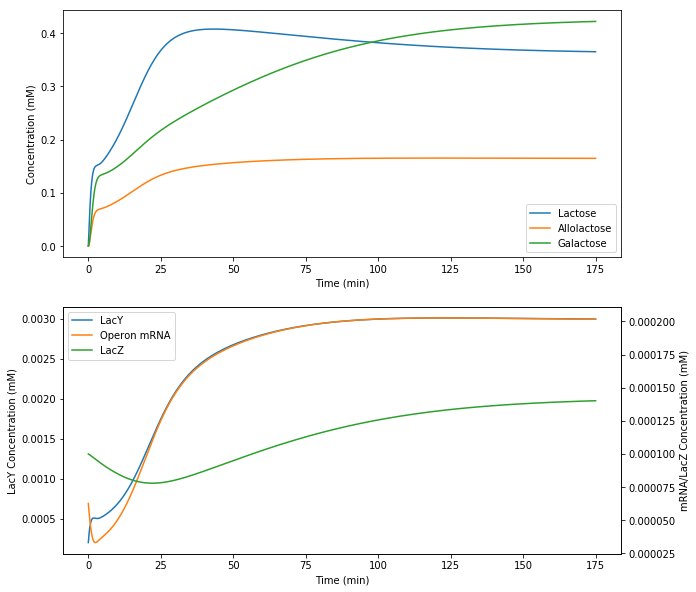

In [8]:
print(("Lactose",L[-1]))
print(("Allolactose", A[-1]))
print(("Galactose", Ga[-1]))
print(("mRNA", mRNA[-1]))
print(("LacY", LacY[-1]))
print(("LacZ", LacZ[-1]))
# Plot metabolite concentrations
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(2,1,1)
ax1.plot(time, L)
ax1.plot(time, A)
ax1.plot(time, Ga)
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Concentration (mM)")
ax1.legend(["Lactose", "Allolactose",  "Galactose"])

# Plot enzyme concentrations
ax2 = fig1.add_subplot(2,1,2)
ax3 = ax2.twinx()
ln1 = ax2.plot(time, LacY, color = 'C0', label='LacY')
ln2 = ax3.plot(time, mRNA, color ='C1', label='Operon mRNA')
ln3 = ax3.plot(time, LacZ, color = 'C2', label='LacZ')
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("LacY Concentration (mM)")
ax3.set_ylabel("mRNA/LacZ Concentration (mM)")

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)
